# Deep learning

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.xception import decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img

%matplotlib inline

<PIL.Image.Image image mode=RGB size=299x299 at 0x7FC5FC0EA5E0>


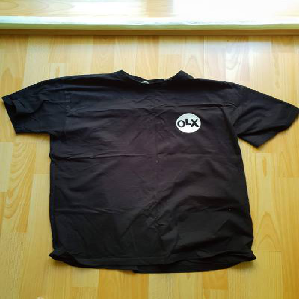

In [2]:
tshirt_path = "data/clothing-dataset-small/train/t-shirt/"
tshirt_name = "5f0a3fa0-6a3d-4b68-b213-72766a643de7.jpg"
tshirt_full_path = f"{tshirt_path}{tshirt_name}"
tshirt = load_img(tshirt_full_path, target_size=(299, 299))
print(tshirt)
tshirt

An image file internally is an array for the three channels (red, green, blue) with each cell in the array representing a pixel with the value from 0-255.

In [3]:
np.array(tshirt)

array([[[179, 171,  99],
        [179, 171,  99],
        [181, 173, 101],
        ...,
        [251, 253, 248],
        [251, 253, 248],
        [251, 253, 248]],

       [[188, 179, 110],
        [187, 178, 109],
        [186, 177, 108],
        ...,
        [251, 252, 247],
        [251, 252, 247],
        [251, 252, 246]],

       [[199, 189, 127],
        [200, 190, 128],
        [200, 190, 128],
        ...,
        [250, 251, 245],
        [250, 251, 245],
        [250, 251, 245]],

       ...,

       [[165, 151,  76],
        [173, 159,  84],
        [171, 157,  82],
        ...,
        [183, 135,  24],
        [181, 133,  22],
        [183, 135,  24]],

       [[165, 151,  76],
        [173, 159,  84],
        [171, 157,  82],
        ...,
        [182, 134,  23],
        [180, 132,  21],
        [182, 134,  23]],

       [[165, 151,  76],
        [173, 159,  84],
        [171, 157,  82],
        ...,
        [181, 133,  22],
        [179, 131,  20],
        [182, 134,  23]]

In Amazon Sagemaker `ml.p2.xlarge` good for neural nets as it has a GPU (8x faster than CPU)

In [4]:
%%time

model = Xception(weights="imagenet", input_shape=(299, 299, 3))

2021-11-19 21:12:36.397835: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-11-19 21:12:36.397864: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-19 21:12:36.397883: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (sleepypioneer-TravelMate-P259-G2-M): /proc/driver/nvidia/version does not exist
2021-11-19 21:12:36.399827: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


91897856/91884032 [==============================] - 4s 0us/step
CPU times: user 2.48 s, sys: 994 ms, total: 3.47 s
Wall time: 6.53 s


In [5]:
x = np.array(tshirt)
x.shape

(299, 299, 3)

In [6]:
X = np.array([x])
X.shape

(1, 299, 299, 3)

In [7]:
X = preprocess_input(X) # apply preprocessing that our model also used

pred = model.predict(X)
decode_predictions(pred)

2021-11-19 21:12:43.590511: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


49152/35363 [=========================================] - 0s 1us/step


[[('n03595614', 'jersey', 0.67924464),
  ('n02916936', 'bulletproof_vest', 0.039600365),
  ('n04370456', 'sweatshirt', 0.035299625),
  ('n03710637', 'maillot', 0.010884146),
  ('n04525038', 'velvet', 0.0018057626)]]

This model only has a `sweatshirt` category and no `tshirt` category.


So we need a new model, good news is we can base it from this model. First lets look under the hood of neural networks.

## Convolutional neural networks (CNN)

- Types of layers: convolutional and dense, we are using convolutional
    - First layer creates feature map by comparing parts of our image with a set of filters (higher values => higher similarity to filter). This results in one feature map per filter
    - From this first layer we create a new image and pass it on to layer two which creates it's own set of feature maps with a new set of filters
    - This process is chained by `n` number of layers each with progressively more complex (often later filters are a combination of earlier filters)
- Result of the layers is a Vector representation of our input image which captures all the information about the image
- We take this vector and for binary classification we can train a logistic regression model on it, calculate the required weights, and use it to output the probability of the image being a certain category using sigmoid (for example a Tshirt)
- For multi classification we will build three models, one for each category (for example: `shirts`, `tshirt`, `dress`) 
    - These models are then used to create an output vector (soft max), which is then used to create predictions. 
    - This layer is called the dense layer (called so because each element of the input is connected to each element of the output). 
    - Simplified a dense layer is matrix multiplication.
    - we can have multiple dense layers
    
    
### How we can use an existing model and train on top of it

- the convolutional layers are quite generic where as the dense layers are specific to the imagenet (dataset)
- so we can take the convolution layers and the outputed vector representation but we want to create our own dense layers (transfer learning)

In [8]:
train_data_path = "./data/clothing-dataset-small/train"
validation_data_path = "./data/clothing-dataset-small/validation"


# allows us to read images from storage and use them for training
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_ds = train_gen.flow_from_directory(
    train_data_path,
    target_size=(150, 150), # using smaller images to get started with
    batch_size=32 # num of images at once
)

Found 3068 images belonging to 10 classes.


In [9]:
# view the classes we have available in our training data
train_ds.class_indices

{'dress': 0,
 'hat': 1,
 'longsleeve': 2,
 'outwear': 3,
 'pants': 4,
 'shirt': 5,
 'shoes': 6,
 'shorts': 7,
 'skirt': 8,
 't-shirt': 9}

In [10]:
X, y = next(train_ds)
X[0]

array([[[ 0.06666672, -0.34117645, -0.32549018],
        [-0.00392157, -0.54509807, -0.52156866],
        [ 0.07450986, -0.49019605, -0.4823529 ],
        ...,
        [ 0.81960785,  0.84313726,  0.88235295],
        [ 0.827451  ,  0.8509804 ,  0.8901961 ],
        [ 0.8509804 ,  0.827451  ,  0.88235295]],

       [[-0.09803921, -0.47450978, -0.49019605],
        [-0.01960784, -0.49019605, -0.49019605],
        [ 0.0196079 , -0.4588235 , -0.46666664],
        ...,
        [ 0.70980394,  0.73333335,  0.77254903],
        [ 0.7254902 ,  0.7490196 ,  0.7882353 ],
        [ 0.8509804 ,  0.84313726,  0.8901961 ]],

       [[-0.02745098, -0.4823529 , -0.49019605],
        [-0.01960784, -0.52156866, -0.52156866],
        [-0.01960784, -0.52156866, -0.52156866],
        ...,
        [ 0.8039216 ,  0.827451  ,  0.8666667 ],
        [ 0.77254903,  0.79607844,  0.8352941 ],
        [ 0.79607844,  0.8039216 ,  0.84313726]],

       ...,

       [[-0.25490195, -0.47450978, -0.5686275 ],
        [-0

In [11]:
y[0] # dress, hat, longsleeve, outwear, pants, shirt, shoes, shorts, skirt, t-shirt

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [12]:
val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = val_gen.flow_from_directory(
    validation_data_path,
    target_size=(150, 150),
    batch_size=32,
    shuffle=False # default is to shuffle but for validation its ok to have them appear in the same order
)

Found 341 images belonging to 10 classes.


In [13]:
%%time

base_model = Xception(
    weights='imagenet',
    include_top=False, # do not include the dense layers!
    input_shape=(150, 150, 3)
)

base_model.trainable = False # when we train the model we do not want to change convolution layers

inputs = keras.Input(shape=(150, 150, 3))

base = base_model(inputs, training=False)

# we invoke the base model as a function to build our neural network

vectors = keras.layers.GlobalAveragePooling2D()(base)

outputs = keras.layers.Dense(10)(vectors)

model = keras.Model(inputs, outputs)

83697664/83683744 [==============================] - 4s 0us/step
CPU times: user 3.07 s, sys: 664 ms, total: 3.74 s
Wall time: 7.57 s


In [14]:
learning_rate = 0.01
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

loss = keras.losses.CategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])

In [15]:
%%time

history = model.fit(train_ds, epochs=4, validation_data=val_ds) # 1 epoch means we go over the dataset once

Epoch 1/4


2021-11-19 21:12:59.339604: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 84934656 exceeds 10% of free system memory.
2021-11-19 21:12:59.448805: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 84934656 exceeds 10% of free system memory.
2021-11-19 21:12:59.550906: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 84934656 exceeds 10% of free system memory.


 1/96 [..............................] - ETA: 11:33 - loss: 2.4346 - accuracy: 0.0312

2021-11-19 21:13:01.132503: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 84934656 exceeds 10% of free system memory.
2021-11-19 21:13:01.203917: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 84934656 exceeds 10% of free system memory.


96/96 [==============================] - 203s 2s/step - loss: 1.2431 - accuracy: 0.6714 - val_loss: 0.9759 - val_accuracy: 0.7654
Epoch 2/4
96/96 [==============================] - 178s 2s/step - loss: 0.6251 - accuracy: 0.8093 - val_loss: 0.9729 - val_accuracy: 0.7713
Epoch 3/4
96/96 [==============================] - 152s 2s/step - loss: 0.3202 - accuracy: 0.8941 - val_loss: 1.0770 - val_accuracy: 0.7713
Epoch 4/4
96/96 [==============================] - 189s 2s/step - loss: 0.2478 - accuracy: 0.9110 - val_loss: 0.9419 - val_accuracy: 0.8035
CPU times: user 31min 1s, sys: 2min 6s, total: 33min 8s
Wall time: 12min 3s


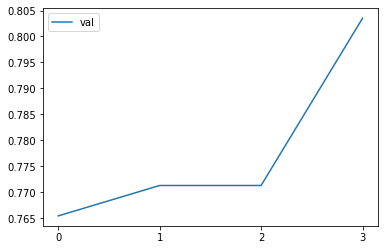

In [16]:
plt.plot(history.history['val_accuracy'], label='val')
plt.xticks(np.arange(4))
plt.legend()

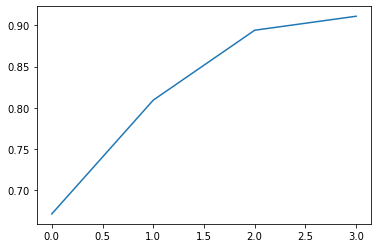

In [17]:
plt.plot(history.history['accuracy'], label='train')

The peak one is probably over fitting or got lucky rather than significantly better. Learning rate parameter is the most important thing to tune.


### Tuning the learning rate

- how fast a model learns
- FAST: High learning rate - consume a lot of learning material quickly but not thorough
- SLOW: Low learning rate - focus on less material but learn it much more thorough
- if we use a high learning rate it could be we perform poorly (overfit) on validation where as a low learning rate may underfit so we have to find the right balance
- we try different parameters to see which gives us the best result

In [18]:
def make_model(learning_rate=0.01):
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(150, 150, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    outputs = keras.layers.Dense(10)(vectors)
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [19]:
%%time

scores = {}

for lr in [0.0001, 0.001, 0.01, 0.1]:
    print(lr)

    model = make_model(learning_rate=lr)
    history = model.fit(train_ds, epochs=4, validation_data=val_ds)
    scores[lr] = history.history

    print()
    print()

0.0001
Epoch 1/4
96/96 [==============================] - 196s 2s/step - loss: 1.8842 - accuracy: 0.3673 - val_loss: 1.5962 - val_accuracy: 0.4751
Epoch 2/4
96/96 [==============================] - 189s 2s/step - loss: 1.3760 - accuracy: 0.5623 - val_loss: 1.2573 - val_accuracy: 0.6364
Epoch 3/4
96/96 [==============================] - 174s 2s/step - loss: 1.1382 - accuracy: 0.6392 - val_loss: 1.0786 - val_accuracy: 0.6862
Epoch 4/4
96/96 [==============================] - 171s 2s/step - loss: 1.0007 - accuracy: 0.6822 - val_loss: 0.9692 - val_accuracy: 0.7243


0.001
Epoch 1/4
96/96 [==============================] - 173s 2s/step - loss: 1.1156 - accuracy: 0.6203 - val_loss: 0.6904 - val_accuracy: 0.7830
Epoch 2/4
96/96 [==============================] - 174s 2s/step - loss: 0.6319 - accuracy: 0.7868 - val_loss: 0.6047 - val_accuracy: 0.7977
Epoch 3/4
96/96 [==============================] - 180s 2s/step - loss: 0.5069 - accuracy: 0.8360 - val_loss: 0.5664 - val_accuracy: 0.8123
Epoch

In [20]:
del scores[0.1]
del scores[0.0001]

CPU times: user 44 ms, sys: 17 µs, total: 44.1 ms
Wall time: 43.1 ms


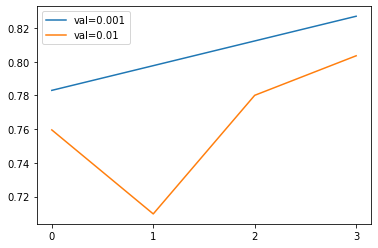

In [21]:
%%time

for lr, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % lr))

plt.xticks(np.arange(4))
plt.legend()

CPU times: user 31.3 ms, sys: 7.93 ms, total: 39.3 ms
Wall time: 40.9 ms


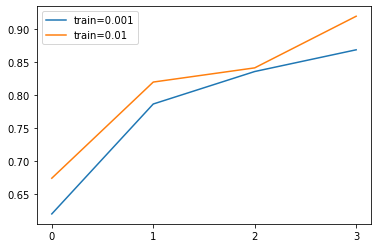

In [22]:
%%time

for lr, hist in scores.items():
    plt.plot(hist['accuracy'], label=('train=%s' % lr))

plt.xticks(np.arange(4))
plt.legend()

In [23]:
learning_rate = 0.001

### Checkpoints

When we train our model for multiple epochs we want to save out the best version of the model. After an epoch is finished we can invoke a call back to get various infomration. We will use the ModelCheckpoint to get the model data

In [24]:
model.save_weights('model_v1.h5', save_format='h5')

In [25]:
chechpoint = keras.callbacks.ModelCheckpoint(
    'xception_v1_{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

In [26]:
learning_rate = 0.001

model = make_model(learning_rate=learning_rate)

history = model.fit(
    train_ds,
    epochs=4,
    validation_data=val_ds,
    callbacks=[chechpoint]
)

Epoch 1/4
96/96 [==============================] - 148s 2s/step - loss: 1.0826 - accuracy: 0.6382 - val_loss: 0.7340 - val_accuracy: 0.7801


/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/4
96/96 [==============================] - 144s 1s/step - loss: 0.6209 - accuracy: 0.7855 - val_loss: 0.6214 - val_accuracy: 0.8065
Epoch 3/4
96/96 [==============================] - 147s 2s/step - loss: 0.5074 - accuracy: 0.8321 - val_loss: 0.6272 - val_accuracy: 0.8094
Epoch 4/4
96/96 [==============================] - 143s 1s/step - loss: 0.4319 - accuracy: 0.8523 - val_loss: 0.5703 - val_accuracy: 0.8240


### Adding more layers

Softmax (Activation) it takes raw scores from the dense layer and transforms them into probabilities
We don't use softmax because we use layers directly but it's somewhat implied.

Each layer in a NN has some level of transformation. There are different activation functions we can use (ie sigmoid or softmax for output or ReLU (default and very popular) and others for intermediate layers.

In [27]:
def make_model(learning_rate=0.01, size_inner=100):
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(150, 150, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    
    outputs = keras.layers.Dense(10)(inner)
    
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [28]:
learning_rate = 0.001

scores = {}

for size in [10, 100, 1000]:
    print(size)

    model = make_model(learning_rate=learning_rate, size_inner=size)
    history = model.fit(train_ds, epochs=4, validation_data=val_ds)
    scores[size] = history.history

    print()
    print()

10
Epoch 1/4
96/96 [==============================] - 151s 2s/step - loss: 1.6420 - accuracy: 0.4658 - val_loss: 1.2364 - val_accuracy: 0.6217
Epoch 2/4
96/96 [==============================] - 144s 1s/step - loss: 1.0055 - accuracy: 0.7024 - val_loss: 0.8880 - val_accuracy: 0.7155
Epoch 3/4
96/96 [==============================] - 144s 2s/step - loss: 0.7599 - accuracy: 0.7601 - val_loss: 0.7544 - val_accuracy: 0.7566
Epoch 4/4
96/96 [==============================] - 142s 1s/step - loss: 0.6243 - accuracy: 0.7963 - val_loss: 0.6863 - val_accuracy: 0.7683


100
Epoch 1/4
96/96 [==============================] - 145s 1s/step - loss: 1.0092 - accuracy: 0.6594 - val_loss: 0.6302 - val_accuracy: 0.7830
Epoch 2/4
96/96 [==============================] - 144s 2s/step - loss: 0.5452 - accuracy: 0.8149 - val_loss: 0.5561 - val_accuracy: 0.8006
Epoch 3/4
96/96 [==============================] - 145s 2s/step - loss: 0.3883 - accuracy: 0.8677 - val_loss: 0.5834 - val_accuracy: 0.7918
Epoch 4/4
9

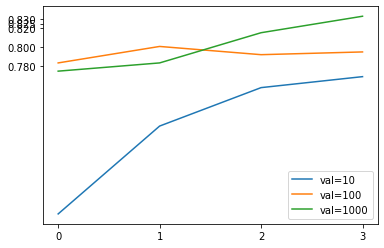

In [29]:
for size, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % size))

plt.xticks(np.arange(4))
plt.yticks([0.78, 0.80, 0.82, 0.825, 0.83])
plt.legend()

## Regularisation and dropout

In [30]:
def make_model(learning_rate=0.01, size_inner=100, droprate=0.5):
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(150, 150, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    drop = keras.layers.Dropout(droprate)(inner)
    
    outputs = keras.layers.Dense(10)(drop)
    
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [31]:
learning_rate = 0.001
size = 100

scores = {}

for droprate in [0.0, 0.2, 0.5, 0.8]:
    print(droprate)

    model = make_model(
        learning_rate=learning_rate,
        size_inner=size,
        droprate=droprate
    )

    history = model.fit(train_ds, epochs=8, validation_data=val_ds)
    scores[droprate] = history.history

    print()
    print()

0.0
Epoch 1/8
96/96 [==============================] - 145s 1s/step - loss: 0.9627 - accuracy: 0.6767 - val_loss: 0.6979 - val_accuracy: 0.7537
Epoch 2/8
96/96 [==============================] - 146s 2s/step - loss: 0.4968 - accuracy: 0.8347 - val_loss: 0.5790 - val_accuracy: 0.7918
Epoch 3/8
96/96 [==============================] - 146s 2s/step - loss: 0.3452 - accuracy: 0.8827 - val_loss: 0.6026 - val_accuracy: 0.8035
Epoch 4/8
96/96 [==============================] - 146s 2s/step - loss: 0.2585 - accuracy: 0.9211 - val_loss: 0.5891 - val_accuracy: 0.8006
Epoch 5/8
96/96 [==============================] - 143s 1s/step - loss: 0.1656 - accuracy: 0.9580 - val_loss: 0.5383 - val_accuracy: 0.8387
Epoch 6/8
96/96 [==============================] - 142s 1s/step - loss: 0.1244 - accuracy: 0.9729 - val_loss: 0.6298 - val_accuracy: 0.7947
Epoch 7/8
96/96 [==============================] - 140s 1s/step - loss: 0.0865 - accuracy: 0.9853 - val_loss: 0.5630 - val_accuracy: 0.8182
Epoch 8/8
96/96 

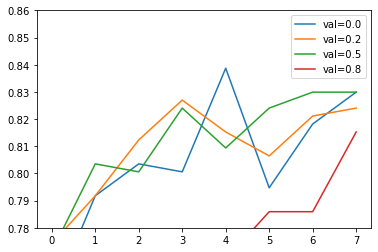

In [32]:
for droprate, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % droprate))

plt.ylim(0.78, 0.86)
plt.legend()

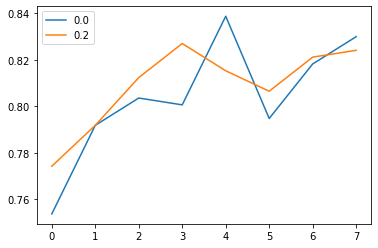

In [33]:
hist = scores[0.0]
plt.plot(hist['val_accuracy'], label=0.0)

hist = scores[0.2]
plt.plot(hist['val_accuracy'], label=0.2)

plt.legend()

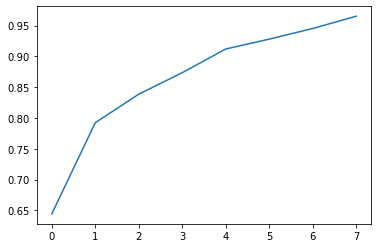

In [34]:
plt.plot(hist['accuracy'], label=('val=%s' % droprate))

### 8.10 Data augmentation

In [37]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
#     vertical_flip=True,
)

train_ds = train_gen.flow_from_directory(
    './data/clothing-dataset-small/train',
    target_size=(150, 150),
    batch_size=32
)

val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = val_gen.flow_from_directory(
    './data/clothing-dataset-small/validation',
    target_size=(150, 150),
    batch_size=32,
    shuffle=False
)

Found 3068 images belonging to 10 classes.
Found 341 images belonging to 10 classes.


### Train a bigger model

In [38]:
def make_model(input_size=150, learning_rate=0.01, size_inner=100,
               droprate=0.5):

    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(input_size, input_size, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(input_size, input_size, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    drop = keras.layers.Dropout(droprate)(inner)
    
    outputs = keras.layers.Dense(10)(drop)
    
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [39]:
input_size = 299

In [41]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=10,
    zoom_range=0.1,
    horizontal_flip=True
)

train_ds = train_gen.flow_from_directory(
    './data/clothing-dataset-small/train',
    target_size=(input_size, input_size),
    batch_size=32
)


val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = train_gen.flow_from_directory(
    './data/clothing-dataset-small/validation',
    target_size=(input_size, input_size),
    batch_size=32,
    shuffle=False
)

Found 3068 images belonging to 10 classes.
Found 341 images belonging to 10 classes.


In [42]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_v4_1_{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

In [43]:
learning_rate = 0.0005
size = 100
droprate = 0.2

model = make_model(
    input_size=input_size,
    learning_rate=learning_rate,
    size_inner=size,
    droprate=droprate
)

history = model.fit(train_ds, epochs=10, validation_data=val_ds,
                   callbacks=[checkpoint])

Epoch 1/10
96/96 [==============================] - 818s 8s/step - loss: 1.0161 - accuracy: 0.6714 - val_loss: 0.5504 - val_accuracy: 0.8270
Epoch 2/10
96/96 [==============================] - 797s 8s/step - loss: 0.5441 - accuracy: 0.8155 - val_loss: 0.4573 - val_accuracy: 0.8504
Epoch 3/10
96/96 [==============================] - 790s 8s/step - loss: 0.4461 - accuracy: 0.8501 - val_loss: 0.3848 - val_accuracy: 0.8739
Epoch 4/10
22/96 [=====>........................] - ETA: 9:29 - loss: 0.3691 - accuracy: 0.8849

KeyboardInterrupt: 

In [ ]:
hist = scores[0.0]
plt.plot(hist['val_accuracy'], label=0.0)

hist = scores[0.2]
plt.plot(hist['val_accuracy'], label=0.2)

plt.legend()

In [ ]:
plt.plot(hist['accuracy'], label=('val=%s' % droprate))

### 8.12 Using the model

In [ ]:
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_ds = test_gen.flow_from_directory(
    './data/clothing-dataset-small/test',
    target_size=(299, 299),
    batch_size=32,
    shuffle=False
)

In [ ]:
model = keras.models.load_model('xception_v4_1_13_0.903.h5')

In [ ]:
model.evaluate(test_ds)

In [ ]:
path = 'data/clothing-dataset-small/test/pants/c8d21106-bbdb-4e8d-83e4-bf3d14e54c16.jpg'

In [ ]:
img = load_img(path, target_size=(299, 299))

In [ ]:
x = np.array(img)
X = np.array([x])
X.shape

In [ ]:
X = preprocess_input(X)
pred = model.predict(X)

In [ ]:
classes = [
    'dress',
    'hat',
    'longsleeve',
    'outwear',
    'pants',
    'shirt',
    'shoes',
    'shorts',
    'skirt',
    't-shirt'
]

In [ ]:
dict(zip(classes, pred[0]))

### Summary